In [ ]:
#-----------------------------------------------------------------------------#

# System setup

In [1]:
import pyodbc
import sys

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

# Prospective power analysis

In [3]:
def progress_bar(value, endvalue, bar_length=20):
        percent = float(value) / endvalue
        arrow = '-' * int(round(percent * bar_length)-1) + '>'
        spaces = ' ' * (bar_length - len(arrow))
        sys.stdout.write("\rProgress: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
        sys.stdout.flush()

In [4]:
# Create necessary data frames.
nachfrage_ist_df  = vkb_df.kaufsumme.copy()
nachfrage_soll_df = vkb_df.kaufsumme.copy()
nachfrage_soll_df.loc[nachfrage_soll_df > 0] = nachfrage_ist_df - nachfrage_ist_df.mean() + 25.7

In [42]:
def bootstrap_replicate(nachfrage_ist_df, nachfrage_soll_df, n):
    """Generate bootstrap replicate."""

    # Sample Nachfrage IST.
    bs_nachfrage_ist = np.random.choice(nachfrage_ist_df, size=n)
    
    # Sample Nachfrage SOLL.
    bs_nachfrage_soll = np.random.choice(nachfrage_soll_df, size=n)
    
    # Sample Einlösequote IST.
    e_quote_ist_df  = np.random.binomial(n=1, p=0.31, size=n)
    
    # Sample Einlösequote SOLL.
    e_quote_soll_df = np.random.binomial(n=1, p=0.90, size=n)
     
    # Comute Kosten IST.
    kosten_ist = sum(bs_nachfrage_ist  > 0) * e_quote_ist_df.mean()  * 4.85 # 5.99 abzüglich 19% MWST
    
    # Compute Kosten SOLL.
    kosten_soll = sum(bs_nachfrage_soll > 0) * e_quote_soll_df.mean() * 4.85
    
    # Compute bootstrap replicate, here, Kosten-Nachfrage-Relation.
    return (kosten_soll - kosten_ist) /  (bs_nachfrage_soll.sum() - bs_nachfrage_ist.sum())

In [57]:
traffic_per_day = int(len(nachfrage_ist_df)/7)
n = traffic_per_day*7 # starting point for sample size
power_reps = 1
bs_reps = 1000
target_fulfilled = []
estimated_power = 0.0

while estimated_power < 0.80:
    print("N:" + str(n))
    data_ist      = nachfrage_ist_df[:n]
    data_soll     = nachfrage_ist_df[:n]
    bs_replicates = np.empty(bs_reps)
    
    # Estimate power.
    for i in range(power_reps):
        print()
        print("Cycle " + str(i) + " of " + str(reps_power))
        
        # Estimate distribution of sample statistic.
        for j in range(bs_reps):
            progress_bar(j, bs_reps)
            bs_replicate = bootstrap_replicate(nachfrage_ist_df, nachfrage_soll_df, n)
            bs_replicates[j] = bs_replicate
        target_fulfilled.append(np.percentile(bs_replicates, [2.5, 97.5])[1] < 0.168)  
    estimated_power =sum(target_fulfilled)/len(target_fulfilled)
    print()
    print("Estimated power: " + str(estimated_power))
    if estimated_power < 0.80: n = n + traffic_per_day

N:1160705

Cycle 0 of 1
Progress: [------------------->] 100%
Estimated power: 1.0


In [58]:
target_fulfilled

[True]

In [59]:
np.percentile(bs_replicates, [2.5, 97.5])

array([ 0.13325051,  0.16683594])

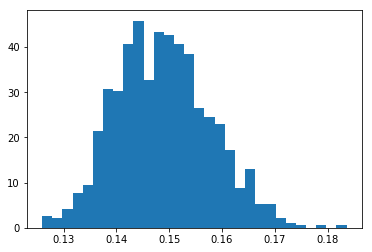

In [60]:
_ = plt.hist(bs_replicates, bins=30, normed=True)
plt.show()